## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
import os
import numpy as np
import math
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda
from numba import vectorize, int64, float64, float32
import matplotlib.pyplot as plt

In [2]:
@vectorize([float64(float64)], target='parallel', fastmath=True) 
def vec_log(x):
    c =  np.log(x)
    return c

@vectorize([float64(float64)], target='parallel', fastmath=True) 
def vec_exp(x):
    c =  np.exp(x)
    return c

A = np.array([2, 5, 10, 3, 8])

logA = vec_log(A)
expA = vec_exp(A)


print('The vectorized version of log is: {}'.format(logA))
print('The vectorized version of exp is: {}'.format(expA))

The vectorized version of log is: [0.69314718 1.60943791 2.30258509 1.09861229 2.07944154]
The vectorized version of exp is: [7.38905610e+00 1.48413159e+02 2.20264658e+04 2.00855369e+01
 2.98095799e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

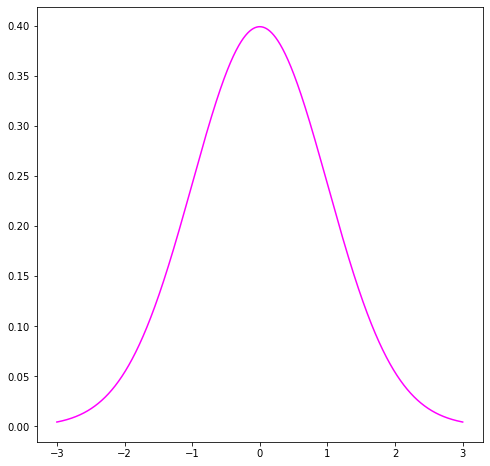

In [3]:
@vectorize([float64(float32)], target='parallel', fastmath=True) 
def vectorized_gaussian(x):
    return 1/np.sqrt(2*np.pi) * np.exp(-x**2/2)

size = 100000
x =  np.linspace(-3, 3, size, dtype = np.float32)

plt.figure(figsize=(8, 8))
plt.plot(x, vectorized_gaussian(x), color='magenta')
plt.show()

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

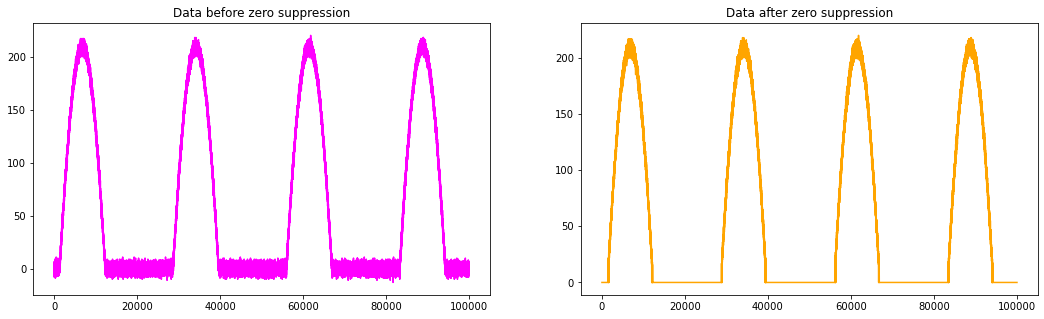

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

#put your code here
@vectorize([float32(float32, float32)], target = 'parallel', fastmath = True)
def zero_suppression(x, treshold):
    return x * (x > treshold)

treshold = 15
fig,ax = plt.subplots(1,2, figsize=(18, 5))

ax[0].plot(data, color='magenta')
ax[0].set_title('Data before zero suppression')
ax[1].plot(zero_suppression(data,treshold), color='orange')
ax[1].set_title('Data after zero suppression')
plt.show()    

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [5]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

@jit(nopython=True)
def sigmoid_kernel(x, y, alpha, c):
    return np.tanh(alpha*np.dot(x.T,y) + c)

print('The Sigmoid kernel between matrix X and Y is:', '\n', sigmoid_kernel(X,Y,1,0))

The Sigmoid kernel between matrix X and Y is: 
 [[0.41479455 0.48398912 0.26981715]
 [0.46116562 0.13428566 0.50236201]
 [0.56296425 0.25524279 0.56366571]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [6]:
@cuda.jit
def cos_kernel_3D(data):
    row, col, depth = cuda.grid(3)
    if row < data.shape[0] and col < data.shape[1] and depth < data.shape[2]:
        data[row][col][depth] =  math.cos(data[row][col][depth]) 
 
#Randomly generated matrix
data = np.random.rand(256,256,256)

#Configure the blocks
threadsperblock = (8,8,8) #ThreadsPerBlock must be a divisor of the data dimension: 1024/ 64 / 16 = 1
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

print(data)

[[[0.04912683 0.22332746 0.71706603 ... 0.99444415 0.80498498 0.05811183]
  [0.41500708 0.37345304 0.06621773 ... 0.04597754 0.15389003 0.61466842]
  [0.05154467 0.50080599 0.81872855 ... 0.36900771 0.80295089 0.70681287]
  ...
  [0.67747463 0.41502091 0.54184036 ... 0.81895722 0.20586663 0.979245  ]
  [0.71884037 0.2836784  0.51349668 ... 0.24703622 0.37525995 0.07352797]
  [0.05273992 0.97751008 0.2047819  ... 0.79156497 0.71865599 0.89971154]]

 [[0.72634407 0.72801129 0.8765754  ... 0.71019054 0.83737769 0.37578537]
  [0.24226068 0.64721677 0.56613774 ... 0.78201006 0.40954854 0.60054302]
  [0.06085135 0.81191503 0.94575342 ... 0.00321394 0.09970902 0.24847048]
  ...
  [0.29778208 0.20762088 0.74699428 ... 0.15748712 0.91293076 0.7977306 ]
  [0.59996324 0.83113744 0.04940987 ... 0.71933648 0.50759621 0.55385033]
  [0.83415712 0.50992435 0.43806    ... 0.63544722 0.01306354 0.14390038]]

 [[0.13852367 0.40407702 0.26854025 ... 0.55253306 0.97870892 0.91284545]
  [0.66706741 0.198471

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [7]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(1,10,(24,12))
B = np.random.randint(1,10,(12,22))
C = np.zeros((24,22))

# Configure the blocks
threadsperblock = (4,2)
blockspergrid_x = int(math.ceil(C.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(C.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)


matmul[blockspergrid, threadsperblock](A, B, C)


print(C)


[[317. 414. 446. 303. 411. 190. 327. 312. 262. 360. 407. 433. 428. 409.
  380. 359. 290. 384. 409. 328. 330. 430.]
 [389. 490. 481. 381. 447. 207. 337. 373. 232. 375. 432. 413. 397. 407.
  386. 396. 267. 439. 447. 358. 328. 405.]
 [324. 385. 409. 273. 391. 178. 290. 262. 202. 309. 348. 394. 362. 397.
  366. 313. 246. 358. 380. 275. 315. 395.]
 [209. 316. 281. 201. 274. 132. 239. 241. 182. 242. 301. 335. 283. 262.
  236. 238. 202. 279. 274. 254. 223. 265.]
 [238. 292. 294. 181. 269. 145. 209. 214. 159. 257. 296. 286. 289. 296.
  251. 238. 187. 271. 258. 228. 241. 268.]
 [268. 327. 350. 209. 344. 121. 226. 246. 185. 240. 280. 276. 307. 323.
  306. 311. 194. 336. 296. 241. 261. 321.]
 [305. 355. 384. 296. 348. 180. 250. 277. 220. 311. 397. 367. 387. 346.
  300. 281. 231. 320. 397. 294. 265. 357.]
 [412. 463. 470. 357. 422. 231. 339. 330. 246. 395. 478. 489. 417. 424.
  406. 385. 309. 411. 470. 402. 392. 417.]
 [254. 281. 332. 228. 308. 150. 214. 202. 182. 239. 280. 298. 301. 332.
  287. 2